# MT1D layered earth: Sharp and Smooth features with PGI

_This notebook was adapted from_ https://github.com/simpeg/tle-magnetotelluric_inversion

### This notebook reproduces the MT example from Astic & Oldenburg 2019.

Magnetotelluric data are acquired over a layered-earth that has sharp and smooth features. The earth model consists of a background unit of $0.01~\text{S/m}$, a $900~\text{m}$ thick resistive unit with sharp contrast starting at a depth of $100~\text{m}$ with a conductivity of $5\cdot10^{-3}~\text{S/m}$ (or $200~\Omega \text{m}$), and a deeper smooth conductor with a minimum resistivity of $10~\Omega \text{m}$, starting at a depth of $2,300~\text{m}$ and finishing at a depth of $7,560~\text{m}$. We discretize this model on a $89$ cells. 

The PGI algorithm is provided with the true GMM and the goal is to use it along with the MT data to find a solution that has the desired features.

In [1]:
# Initial import
from scipy.constants import mu_0
import scipy.sparse as sp
from SimPEG import (
    Mesh, Problem, Survey, Maps, Utils, EM, DataMisfit,
    Regularization, Optimization, InvProblem,
    Directives, Inversion)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import StrMethodFormatter,FormatStrFormatter
from sklearn.mixture import GaussianMixture
from pymatsolver import PardisoSolver as Solver
import sys
import copy
from tleMT.MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx

from PGI_examples_Utils import weighted_avg_and_var, omega, appres_phase_from_data

# Better rendering
import seaborn
seaborn.set()

# set a seed to the results are reproducible
np.random.seed(1)  


## Setup

In [2]:
# Initialize the Earth-model
layer_tops = np.r_[0., -100., -1000.]  # in m
rho_layers = np.r_[100., 200., 100.]

# Initialize the survey
rxloc = np.r_[0.]
frequency = np.logspace(-3, 3, 25)

# Create a receiver object
rx = ZxyRx(
    rxloc,  # location of the receiver
    component="both",  # measure both the real and imaginary components of the impedance (alternatively "real" / "imag")
    frequency=frequency
)

# create a plane wave source
src = MT1DSrc([rx])

# define a survey
survey = MT1DSurvey([src])

# Define the mesh
max_depth_core = 15000.
mesh = survey.setMesh(
    sigma=0.01,  # approximate conductivity of the background
    max_depth_core=max_depth_core,  # extent of the core region of the mesh
    ncell_per_skind=20,  # number of cells per the smallest skin depth
    n_skind=2,  # number of skin depths that the mesh should extend to ensure the lowest-frequency fields have decayed
    core_meshType="log",   # cell spacings in the core region of the mesh ("linear" or "log")
    max_hz_core=1000.  # If using a logarithmic core mesh, what is the maximum cell size?
 )

# Create the problem
prob = MT1DProblem(
    mesh,  # The mesh contains the geometry, grids, etc necessary for constructing the discrete PDE system
    sigmaMap=Maps.ExpMap(mesh),  # in the inversion, we want to invert for log-conductivity (enforces postivity, electrical conductivity tends to vary logarithmically)
    verbose=False,  # print information as we are setting up and solving
    Solver=Solver  # solver to employ for solving Ax = b
)

# tell the problem and survey about each other so we can construct our matrix system
# and right hand-side
prob.pair(survey)

# start with nans so we can do a check to make sure all
# layer conductivities have been properly assigned
rho = np.ones(mesh.nC) * np.nan

# loop over each layer in the model and assign to mesh
for layer_top, rho_layer in zip(layer_tops, rho_layers):
    inds = mesh.vectorCCx < layer_top
    rho[inds] = rho_layer

# Add a smooth unit
sigma = 1./rho
mtrue = np.log(sigma)
t = (mesh.vectorCCx+5000.)/5e3
indx = np.abs(t) < 1
maux = copy.deepcopy(mtrue)
maux[indx] = (np.log(1./100.)*(1-(((1-t**2.)**2.)))-np.log(10))[indx]
indx = np.logical_and(indx, maux > np.log(1./rho_layers[2]))
mtrue[indx] = maux[indx]
dtrue = survey.dpred(mtrue)  # these are clean data (no noise yet.)

std = 0.02  # standard deviation of the noise (10%)

# add noise
uncertTrue = std * np.abs(dtrue)
noise = uncertTrue * np.random.randn(survey.nFreq*2)
survey.dobs = dtrue + noise
survey.std = std
survey.eps = 0.
uncert = std * np.abs(survey.dobs)

# Compute Apparent resisitivity and phase for visualization
res, phase = appres_phase_from_data(survey)

>> Smallest cell size = 7 m
>> Padding distance = 316227 m
>> # of padding cells 17
>> # of core cells cells 72


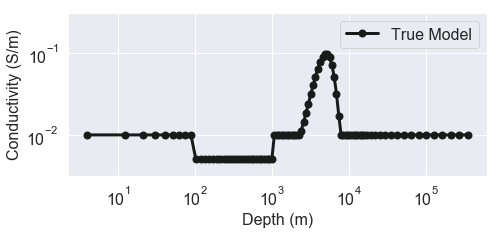

In [3]:
# Plot the true model
fig0 = plt.figure(figsize=(7.5,3))
ax1 = fig0.add_subplot(111)

fontsize=16
M = prob.mesh

plt.loglog(-M.vectorCCx, np.exp(mtrue), 'ko-',linewidth=3,label='True Model',ms=7)
plt.legend(fontsize=fontsize,loc=0)
plt.gca().set_ylim([10**(-2.5),10**(-0.5)])
plt.gca().set_xlabel('Depth (m)',fontsize=fontsize)
plt.gca().tick_params(labelsize=fontsize)
plt.gca().set_ylabel('Conductivity (S/m)',fontsize=fontsize)
plt.show()

#fig0.savefig('MT1D_GroundTruth_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig0.savefig("MT1D_GroundTruth_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

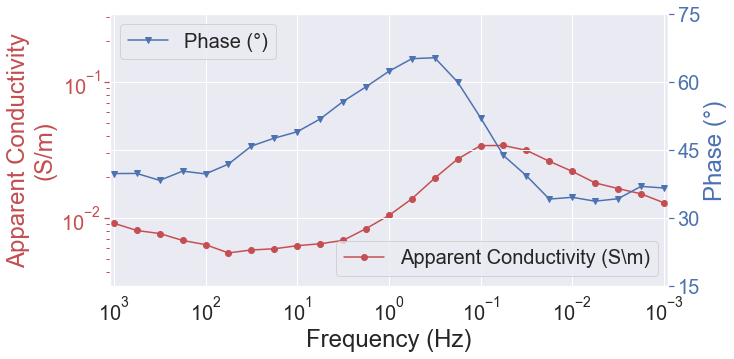

In [4]:
# Plot the Data
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax1 = ax.twinx()
ax.loglog(frequency,1./res,'ro-',label='Apparent Conductivity (S\m)')
ax1.semilogx(frequency,phase,'bv-',label='Phase (°)')
ax.tick_params(labelsize=20)
ax1.tick_params(labelsize=20)
ax.set_xlim([(1e3)+1e2,(1e-3)-1e-4])
ax.set_ylim([10**(-2.5),10**(-0.5)])
ax1.set_yticks([15,30,45,60,75])
ax.set_xlabel("Frequency (Hz)",fontsize=24)
ax.set_ylabel("Apparent Conductivity\n(S/m)",fontsize=24,color='r')
ax1.set_ylabel("Phase (°)",fontsize=24,color='b')
ax1.tick_params(axis='y', which='both', colors='b',labelsize=20)
ax.tick_params(axis='y', which='both', colors='r',labelsize=20)
ax.legend(fontsize=20,loc=4)
ax1.legend(fontsize=20,loc=2)
##fig.savefig('MT1D_Data_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("MT1D_Data_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

## Tikhonov inversion

In [5]:
# Simple Inversion
##################

# Set the initial and reference models
sigma_ref = 1./rho_layers[0]  # reference conductivity
sigma_0 = 1./rho_layers[0]  # starting conductivity

# translate the starting and reference model to log-conductivity
mref = np.log(sigma_ref)*np.ones(mesh.nC)
m0 = np.log(sigma_0)*np.ones(mesh.nC)

# Set weighting parameters
alpha_s = 1e2  # smallness contribution
alpha_z = 20.  # smoothness contribution to the regularization
beta = 4e-1  # Initial beta
beta0_ratio = 10.   # starting contribution of regularization 10x larger than the data misfit
coolingFactor = 1.5
coolingRate = 1

# Data misfit
dmisfit = DataMisfit.l2_DataMisfit(survey,std=0.02)
#dmisfit.W = 1./uncert

# Regularization
reg = Regularization.Simple(
        prob.mesh, alpha_s=alpha_s, alpha_x=alpha_z, mref=mref
    )  # since we are in 1D, we work with the first dimension

# Optimization
opt = Optimization.ProjectedGNCG(
    maxIter=35, tolX=1e-6, maxIterCG=100, tolCG=1e-3)
opt.remember('xc')

# Statement of the inverse problem
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
invProb.beta = beta

# Inversion Directives
beta = Directives.BetaSchedule(
        coolingFactor=coolingFactor, coolingRate=coolingRate
    )
target = Directives.TargetMisfit()
directives = [beta, target]

# assemble in an inversion
inv = Inversion.BaseInversion(invProb, directiveList=directives)
prob.counter = opt.counter = Utils.Counter()
opt.remember('xc')

# run the inversion
l2model = inv.run(m0)



                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.00e-01  1.73e+04  0.00e+00  1.73e+04    5.32e+03      0              
   1  2.67e-01  7.47e+02  2.25e+03  1.35e+03    4.63e+02      0              
   2  1.78e-01  8.11e+01  2.67e+03  5.56e+02    2.08e+02      0              
   3  1.19e-01  3.19e+01  2.53e+03  3.32e+02    4.84e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.7283e+03
0 : |xc-x_last| = 7.9872e-01 <= tolX*(1+|x0|) = 4.4445e-05
0 : |proj(x-g)-x|    = 4.8367e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)

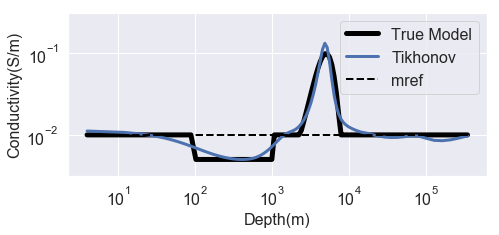

In [6]:
# Plot the Tikhonv inversion result
M = mesh
fontsize=16
fig,ax0 = plt.subplots(1,1,figsize=(7.5,3))
ax0.loglog(-M.vectorCCx, np.exp(mtrue),color='black', linewidth=5.)
ax0.loglog(-M.vectorCCx, np.exp(l2model),color='b', linewidth=3.)
ax0.loglog(-M.vectorCCx, np.exp(m0),
             color='black',
             linestyle='dashed',
          linewidth=2)

plt.legend(['True Model',
            'mref',
            'Petro',
            'L2 model'],fontsize=fontsize,loc=0)
plt.gca().set_ylim([10**(-2.5),10**(-0.5)])


plt.gca().set_xlabel('Depth (m)',fontsize=fontsize)
plt.gca().tick_params(labelsize=fontsize)
plt.gca().set_ylabel('Conductivity (S/m)',fontsize=fontsize)
ax0.legend(('True Model', 'Tikhonov', 'mref'),loc=0,fontsize=fontsize)
ax0.set_xlabel("Depth(m)",fontsize=fontsize)
fig.canvas.draw()
ax0.set_ylabel("Conductivity(S/m)",fontsize=fontsize)
ax0.tick_params(labelsize=fontsize)
#fig.savefig('MT1D_L2_std2percent_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("MT1D_L2_std2percent_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

## PGI

In [7]:
# Compute the GMM parameters for each units
bckgdmean = -np.log(100)
bckgrdvar = 0.01
bckgrdprop = np.sum(mesh.vol[np.isclose(bckgdmean,mtrue)])/np.sum(mesh.vol)

resmean = -np.log(200)
resvar = 0.01
resprop = np.sum(mesh.vol[np.isclose(resmean,mtrue)])/np.sum(mesh.vol)


condmean, condvar = weighted_avg_and_var(maux[indx],weights=mesh.vol[indx])
condprop = 1. -( bckgrdprop + resprop)

In [8]:
# Create the Prior GMM
######################
means_init = np.r_[-np.log(100), condmean, -np.log(200)][:,np.newaxis]
clf = Utils.WeightedGaussianMixture(n_components=3,
                                    mesh=mesh,
                      covariance_type='full',
                      max_iter=1000,
                      n_init=1,
                      reg_covar=4e-3,
                     means_init=means_init)
clf.fit(mtrue.reshape(-1, 1))
Utils.order_clusters_GM_weight(clf)

clf.covariances_ = np.array([[[0.01]],
                             [[condvar]],
                             [[0.01]],
                             ])
clf.means_ =means_init
clf.weights_ = np.r_[bckgrdprop,condprop,resprop]
clf.precisions_cholesky_ = Utils.petroutils._compute_precision_cholesky(clf.covariances_, clf.covariance_type)
Utils.petroutils.computePrecision(clf)

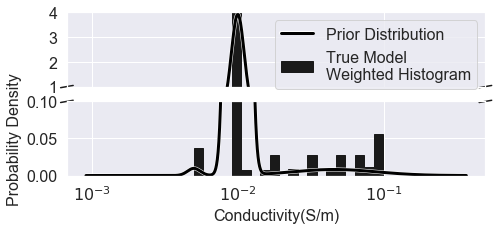

In [9]:
# Plot the Prior GMM distribution
fig0, (ax, ax3) = plt.subplots(2, 1, sharex=True,figsize=(7.5,3))
fontsize=16
M = prob.mesh
testXplot = np.linspace(-7.,-1.,1000)[:,np.newaxis];
clfinv = clf
log_dens0 = clf.score_samples(testXplot);
log_dens = clfinv.score_samples(testXplot);
ax3.plot(np.log10(np.exp(testXplot)), np.exp(log_dens0),linewidth =3.,color='black',
         path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()]
        )

ax3.set_xticks([-3,-2,-1])
ax3.tick_params(labelsize=fontsize)
ax3.xaxis.set_major_formatter(FormatStrFormatter('$10^{%.0f}$'))
ax3.set_xlabel('Conductivity(S/m)',fontsize=fontsize)
ax3.hist(np.log10(np.exp((mtrue))),density = True, bins = 20,color='k',ec='k', weights=mesh.vol);
ax3.set_ylim([0.,0.1])
ax3.set_ylabel("Probability Density",fontsize=fontsize)

ax.hist(np.log10(np.exp((mtrue))),density = True, bins = 20,color='k',ec='k', weights=mesh.vol/np.sum(mesh.vol));
ax.tick_params(labelsize=fontsize)
ax.plot(np.log10(np.exp(testXplot)), np.exp(log_dens0),linewidth =3.,color='black',
         path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()]
        )

ax.set_ylim([1.,4.])
ax.set_yticks([1,2,3,4])
ax.legend(['Prior Distribution','True Model\nWeighted Histogram','$m_0$ Hist'],loc=1,fontsize=fontsize)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
ax3.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax3.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.show()

#fig0.savefig('MT1D_GroundTruth_Dist_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig0.savefig("MT1D_GroundTruth_Dist_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

In [10]:
# Petrophysics Inversion
########################

# Data misfit
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert

reg_petro = Regularization.MakeSimplePetroRegularization(GMmref=clf,
                                               GMmodel=clf,
                                               mesh=prob.mesh,
                                               mref=m0,
                                               cell_weights_list = [np.ones(mesh.nC)])
reg_petro.mrefInSmooth = False

# Weightings
reg_petro.objfcts[0].alpha_s = 1.
reg_petro.objfcts[0].alpha_x = 0
reg_petro.objfcts[0].alpha_y = 0
reg_petro.objfcts[0].alpha_z = 0.

reg_petro.objfcts[1].alpha_s = 0.
reg_petro.objfcts[1].alpha_x = 20.


opt = Optimization.ProjectedGNCG(
    maxIter=15, tolX=1e-6, maxIterCG=100, tolCG=1e-3)
opt.remember('xc')

# Statement of the inverse problem
invProb = InvProblem.BaseInvProblem(dmisfit, reg_petro, opt)
invProb.beta =4e-1

# Directives
targets = Directives.PetroTargetMisfit(
    TriggerSmall=True, TriggerTheta=False, verbose=True)
betaIt = Directives.PetroBetaReWeighting(
    verbose=True, rateCooling=8., rateWarming=1.,
    tolerance=0.02, UpdateRate=1,
    ratio_in_cooling=False,
    progress=0.1,
)
petrodir = Directives.GaussianMixtureUpdateModel(
    verbose=False,
    update_covariances=True,
    nu = 1.,
    kappa= 1.,
    alphadir= 1.)



directives = [
              petrodir, 
              targets,
              betaIt, 
]

# assemble in an inversion
inv = Inversion.BaseInversion(invProb, directiveList=directives)

# run the inversion
mcluster = inv.run(m0)



                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.00e-01  1.73e+04  0.00e+00  1.73e+04    5.32e+03      0              
DM:  [747.23446657] [False] ; CL:  88.24930461654172 False ; DP:  True ; All: False
progress [747.23446657] >< [15553.74121558]
   1  4.00e-01  7.47e+02  9.12e+01  7.84e+02    5.43e+02      0              
DM:  [166.78757411] [False] ; CL:  75.49171852533105 False ; DP:  True ; All: False
progress [166.78757411] >< [672.51101991]
   2  4.00e-01  1.67e+02  8.86e+01  2.02e+02    4.09e+02      0              
DM:  [29.99275347] [False] ; CL:  63.657092408377885 False ; DP:  True ; All

Text(0, 0.5, 'Conductivity (S/m)')

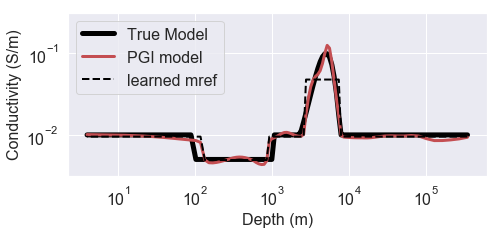

In [11]:
# PGI model
fig,ax0 = plt.subplots(1,1,figsize=(7.5,3))
fontsize=16
M = prob.mesh
plt.loglog(-M.vectorCCx, np.exp(mtrue), color='black',linewidth=5)

plt.loglog(-M.vectorCCx, np.exp(mcluster), color='r',linewidth=3)
plt.loglog(-M.vectorCCx, np.exp(reg_petro.objfcts[0].mref),
             color='black',
             linestyle='dashed',
          linewidth=2)

plt.legend(['True Model',
            'PGI model',
            'learned mref',
],fontsize=fontsize,loc=0)
plt.gca().set_ylim([10**(-2.5),10**(-0.5)])


plt.gca().set_xlabel('Depth (m)',fontsize=fontsize)
plt.gca().tick_params(labelsize=fontsize)
plt.gca().set_ylabel('Conductivity (S/m)',fontsize=fontsize)

#fig.savefig('MT1D_petro_std2percent_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig.savefig("MT1D_petro_std2percent_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)

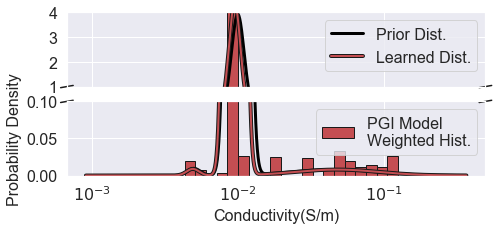

In [12]:
# Plot Histogram and learned petrophysical distribution
fig0, (ax, ax3) = plt.subplots(2, 1, sharex=True,figsize=(7.5,3))
fontsize=16
M = prob.mesh
testXplot = np.linspace(-7.,-1.,1000)[:,np.newaxis];
clfref = invProb.reg.objfcts[0].GMmref
clfinv = invProb.reg.objfcts[0].GMmodel
log_dens0 = clf.score_samples(testXplot);
log_dens = clfinv.score_samples(testXplot);

ax3.plot(np.log10(np.exp(testXplot)), np.exp(log_dens0),linewidth =3.,color='black')
ax3.plot(np.log10(np.exp(testXplot)), np.exp(log_dens),linewidth =2.,color='r',
        #label='Learned Dist',
        path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

ax3.set_xticks([-3,-2,-1])
ax3.tick_params(labelsize=fontsize)
ax3.xaxis.set_major_formatter(FormatStrFormatter('$10^{%.0f}$'))
ax3.set_xlabel('Conductivity(S/m)',fontsize=fontsize)

ax3.hist(np.log10(np.exp((mcluster))),density = True, bins = 20,color='r',ec='k', weights=mesh.vol,
        label='PGI Model\nWeighted Hist.');
ax3.set_ylim([0.,0.1])
ax3.set_ylabel("Probability Density",fontsize=fontsize)

ax.hist(np.log10(np.exp((mcluster))),density = True, bins = 20,color='r',ec='k', weights=mesh.vol/np.sum(mesh.vol));
ax.tick_params(labelsize=fontsize)
testXplot = np.linspace(-7.,-1.,1000)[:,np.newaxis];

ax.plot(np.log10(np.exp(testXplot)), np.exp(log_dens0),linewidth =3.,color='black')
ax.plot(np.log10(np.exp(testXplot)), np.exp(log_dens),linewidth =2.,color='r',
        label='Learned Dist',
        path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

ax.set_ylim([1.,4.])
ax.set_yticks([1,2,3,4])
ax.legend(['Prior Dist.','Learned Dist.',],loc=1,fontsize=fontsize)
ax3.legend(loc=1,fontsize=fontsize)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
ax3.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax3.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


plt.show()
#fig0.savefig('MT1D_Dist_petro_HighRes.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
#fig0.savefig("MT1D_Dist_petro_LowRes.png", dpi=72, bbox_inches='tight', pad_inches=0.1)